# Song Clusters

In [19]:
import os
import json
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

## Set credentials and perform authetification

In [5]:
# define credentials
cid = "XXX"
secret = "XXX"
redirect_uri = "XXX"
username = "XXX"

In [7]:
# Auth
scope = "user-library-read"
token = util.prompt_for_user_token(username, scope, client_id=cid, client_secret=secret, redirect_uri=redirect_uri)

if token:
    sp = spotipy.Spotify(auth = token)
else:
    print("Can't get token for " + username)

## Get saved songs and features

In [8]:
# Fetch saved songs for the user
saved_tracks_df = pd.DataFrame()
track_list = ""
date_added_list = []
artist_list = []
title_list = []

more_songs = True
offset_index = 0

while more_songs: 
    songs = sp.current_user_saved_tracks(offset = offset_index)
    
    for song in songs["items"]:
        
        # add song ids to track list
        track_list += song["track"]["id"] + ","
        
        # add time when the song was added
        date_added_list.append(song["added_at"])
        
        # add title of the song
        title_list.append(song["track"]["name"])
        
        # add all artists of the song
        artists = song["track"]["artists"]
        artists_name = ""
        for artist in artists:
            artists_name += artist["name"] + ","
        artist_list.append(artists_name[:-1])
    
    # get track features and append them to the dataframe
    track_features = sp.audio_features(track_list[:-1])
    temp_df = pd.DataFrame(track_features)
    saved_tracks_df = saved_tracks_df.append(temp_df)
    track_list = ""
    
    if songs["next"] == None:
        more_songs = False
    else:
        offset_index += songs["limit"]

saved_tracks_df["artists"] = artist_list
saved_tracks_df["song_title"] = title_list
saved_tracks_df["date_added"] = date_added_list

In [9]:
saved_tracks_df.head(5)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,type,id,uri,track_href,analysis_url,duration_ms,time_signature,artists,song_title,date_added
0,0.672,0.743,1,-5.000,1,0.0558,0.03770,0.000689,0.299,0.246,...,audio_features,4wOhPUptCNCCJK0OtjFzpy,spotify:track:4wOhPUptCNCCJK0OtjFzpy,https://api.spotify.com/v1/tracks/4wOhPUptCNCC...,https://api.spotify.com/v1/audio-analysis/4wOh...,322075,4,DEADLIFE,Deviant,2020-03-27T11:10:39Z
1,0.746,0.695,4,-7.517,0,0.0400,0.19600,0.026700,0.199,0.861,...,audio_features,4xymOOdANFwko4RpeR961e,spotify:track:4xymOOdANFwko4RpeR961e,https://api.spotify.com/v1/tracks/4xymOOdANFwk...,https://api.spotify.com/v1/audio-analysis/4xym...,258453,4,"Crystal Castles,HEALTH",Crimewave,2020-03-26T22:30:02Z
2,0.651,0.751,8,-7.422,1,0.3180,0.00982,0.000000,0.266,0.844,...,audio_features,7i5LIw3UC2WgqIp798GGx6,spotify:track:7i5LIw3UC2WgqIp798GGx6,https://api.spotify.com/v1/tracks/7i5LIw3UC2Wg...,https://api.spotify.com/v1/audio-analysis/7i5L...,195280,4,Jupiter,Starlighter,2020-03-26T21:58:16Z
3,0.556,0.893,10,-3.766,0,0.0621,0.23900,0.000000,0.123,0.260,...,audio_features,3Q6mwJseOFYBJ10d5CXp4o,spotify:track:3Q6mwJseOFYBJ10d5CXp4o,https://api.spotify.com/v1/tracks/3Q6mwJseOFYB...,https://api.spotify.com/v1/audio-analysis/3Q6m...,253547,4,"Kavinsky,The Weeknd",Odd Look,2020-03-26T21:58:12Z
4,0.777,0.851,10,-3.801,0,0.0844,0.00769,0.000000,0.140,0.698,...,audio_features,5bzaS5tAni5oUpW7bWVdtY,spotify:track:5bzaS5tAni5oUpW7bWVdtY,https://api.spotify.com/v1/tracks/5bzaS5tAni5o...,https://api.spotify.com/v1/audio-analysis/5bza...,163387,4,"G-Eazy,Gunna",I Wanna Rock (feat. Gunna),2020-03-25T14:24:38Z


In [19]:
saved_tracks_df.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms',
       'time_signature', 'artists', 'song_title', 'date_added'],
      dtype='object')

## Clustering
 - select relevant columns
 - standardize
 - run KMeans for k of 1 to 10 and save inertia

In [27]:
# select columns
use_cols = ["danceability", "energy", "loudness", "mode", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo"]
# transform to numpy array
saved_tracks_array = np.array(saved_tracks_df[use_cols])

# standardize values
scaler = StandardScaler()
scaler.fit(saved_tracks_array)
saved_tracks_array = scaler.transform(saved_tracks_array)

# define inertia list
inertia_list = []


for k in range(1, 11, 1):
    # set up model with k clusters
    model = KMeans(n_clusters = k)
    # fit model to data array
    model.fit(saved_tracks_array)
    # append inertia to list
    inertia_list.append(model.inertia_)

## Evaluate results
After 5 clusters, slope becomes linear. -> select k = 5.

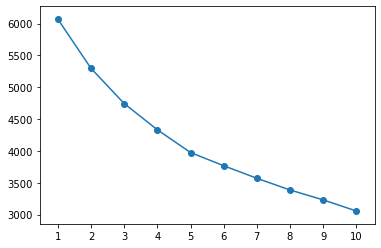

In [28]:
plt.plot(range(1, 11), inertia_list)
plt.scatter(range(1, 11), inertia_list)
plt.xticks(range(1, 11))
plt.show()

In [31]:
# model with k = 5
model = KMeans(n_clusters = 5)
model.fit(saved_tracks_array)

# create new column with cluster labels: cluster_labels
saved_tracks_df["cluster_labels"] = model.labels_

## Create a new playlist for each cluster

In [46]:
# authorization
scope = "playlist-modify-public"
token = util.prompt_for_user_token(username, scope, client_id = cid, client_secret = secret, redirect_uri = redirect_uri)

if token:
    sp = spotipy.Spotify(auth = token)
else:
    print("Can't get token for " + username)

In [53]:
# create a new playlist for each of the clusters
for label in range(0, 5):
    sp.user_playlist_create(username, f"Cluster-{label} playlist", description = f"Contains members of cluster {label}")

In [54]:
def get_playlists(sp, username):
    """returns all playlists for user"""
    
    id = []
    name = []
    num_tracks = []
    
    playlists = sp.user_playlists(username)
    for playlist in playlists["items"]:
        id.append(playlist["id"])
        name.append(playlist["name"])
        num_tracks.append(playlist["tracks"]["total"])
    
    playlists_df = pd.DataFrame({"id":id, "name":name, "num_tracks":num_tracks})
    
    return playlists_df

# get ids for cluster playlists
cluster_playlists = get_playlists(sp, username).head()

In [55]:
def add_songs_to_playlist(df, sp, username, playlist_id):
    """adds songs to a playlist"""
    
    index = 0
    results = []
    
    # get track ids
    tracks = df["id"]
    
    # can only add 100 tracks at a time
    while index < len(tracks):
        results += sp.user_playlist_add_tracks(username, playlist_id, tracks = tracks[index:index + 100])
        index += 100

In [56]:
for label in range(0, 5):
    add_songs_to_playlist(saved_tracks_df.loc[saved_tracks_df["cluster_labels"] == label, :], sp, username, cluster_playlists["id"][label])

In [57]:
get_playlists(sp, username).head()

,id,name,num_tracks
0,4M8cTfcyxz6edeePboKVwW,Cluster-4 playlist,189
1,1da55euuYqaJqNvIDX05Kl,Cluster-3 playlist,208
2,5eGPDDlDgmmFEFXebWSOqx,Cluster-2 playlist,64
3,62tCLUezCTDQUvrgxdPs5h,Cluster-1 playlist,18
4,7HPOoZFyUPfyNOQK9Ezsi9,Cluster-0 playlist,128
